In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
OPEN_API_KEY = os.getenv('OPEN_API_KEY')

LANGSMITH_TRACING = os.getenv('LANGSMITH_TRACING')
LANGSMITH_API_KEY = os.getenv('LANGSMITH_API_KEY')
LANGSMITH_PROJECT = os.getenv('LANGSMITH_PROJECT')
LANGSMITH_ENDPOINT = os.getenv('LANGSMITH_ENDPOINT')

TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
from tavily import TavilyClient

# Initialize Tavily client
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)


In [5]:
from pydantic import BaseModel, Field


from typing import TypedDict, List, Any, Optional, Dict
from typing import Annotated, Literal
from operator import add

In [6]:
class TavilySearchOutput(BaseModel):
    title: str
    url: str
    content: str


In [7]:
class FileRecord(BaseModel):
    path: str
    rel_path: str
    ext: str
    size_bytes: int

class DownloadedDataset(BaseModel):
    provider: Literal["kaggle"]
    source_url: str
    source_id: str
    display_name: Optional[str] = None
    dest_dir: str
    files: List[FileRecord]
    meta: Dict[str, Any] = Field(default_factory=dict)


class SourcingAgentState(TypedDict):
    query: str
    tavilySearchOutput: List[TavilySearchOutput]
    status: Annotated[List[str], add]
    kaggle_urls: List[str]
    #hf_urls: List[str]
    download_results: Annotated[List[DownloadedDataset], add]


In [8]:
# This function takes your search term, looks it up on dataset-heavy sites, filters duplicates, and returns a clean list of dataset pages.

def tavily_search_tool(state: SourcingAgentState):
    """Search Kaggle only and return up to 10 most relevant, deduped dataset links."""
    query = state["query"]

    site_queries = {
        "kaggle": f"{query} dataset site:kaggle.com/datasets"
    }

    def which_site(url: str) -> str | None:
        u = url.lower()
        if "kaggle.com/datasets/" in u:
            return "kaggle"
        return None

    def relevance_score(site: str, title: str, url: str, content: str) -> float:
        t = (title or "").lower()
        u = (url or "").lower()
        c = (content or "").lower()
        score = 0.0
        if any(x in u for x in [".csv", ".xlsx", ".json", "/download", "/raw/"]):
            score += 3.0
        if any(x in c for x in ["csv", "xlsx", "json", "download"]):
            score += 2.0
        for tok in set(query.lower().split()):
            if tok and (tok in t or tok in c):
                score += 0.5
        if site == "kaggle":
            score += 0.5
        return score

    candidates: list[tuple[str, TavilySearchOutput, float]] = []
    seen_urls: set[str] = set()

    # Collect per-site, compute scores (Kaggle only)
    for site, q in site_queries.items():
        try:
            r = tavily_client.search(query=q, search_depth="basic", max_results=15)
        except Exception:
            continue
        if not isinstance(r, dict) or "results" not in r:
            continue
        for h in r["results"]:
            url = h.get("url", "") if isinstance(h, dict) else ""
            site_name = which_site(url) if url else None
            if site_name is None:
                continue
            if url in seen_urls:
                continue
            seen_urls.add(url)
            title = h.get("title", "")
            content = h.get("content", "")
            tso = TavilySearchOutput(title=title, url=url, content=content)
            score = relevance_score(site_name, title, url, content)
            candidates.append((site_name, tso, score))

    candidates.sort(key=lambda x: x[2], reverse=True)

    selected: list[TavilySearchOutput] = []
    used_urls: set[str] = set()

    for _, tso, _ in candidates:
        if len(selected) >= 10:
            break
        if tso.url in used_urls:
            continue
        selected.append(tso)
        used_urls.add(tso.url)

    return { "tavilySearchOutput": selected, "status": ["Gathered Kaggle urls"] }

# Get datasest from Kaggle

## Tool to download Kaggle Files: download_kaggle_files

In [9]:
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import re
from pathlib import Path
from typing import List


def download_kaggle_files(state: SourcingAgentState, data_dir: str = './data') -> dict:
    """
    Download each Kaggle URL into its own folder and return structured bundles for UI/analysis.
    """

    urls = state.get('kaggle_urls', [])

    api = KaggleApi()
    api.authenticate()

    base_dir = Path(data_dir) / 'kaggle'
    base_dir.mkdir(parents=True, exist_ok=True)

    def sanitize_slug(slug: str) -> str:
        # 'owner/name' -> 'owner__name' and strip unsafe chars
        return re.sub(r'[^a-zA-Z0-9._-]+', '_', slug.replace('/', '__'))

    bundles: List[DownloadedDataset] = []

    for url in urls:
        # Extract dataset slug from URL
        m = re.search(r'kaggle\.com/datasets/([^/]+/[^/?#]+)', url)
        if not m:
            continue
        slug = m.group(1)
        owner = slug.split('/')[0]
        name = slug.split('/')[-1]

        dest_dir = base_dir / sanitize_slug(slug)
        dest_dir.mkdir(parents=True, exist_ok=True)

        api.dataset_download_files(
            slug,
            path=str(dest_dir),
            force=False,
            quiet=True,
            unzip=True
        )

        files: List[FileRecord] = []
        for p in dest_dir.rglob('*'):
            if p.is_file():
                try:
                    size = p.stat().st_size
                except Exception:
                    size = 0
                files.append(FileRecord(
                    path=str(p.resolve()),
                    rel_path=str(p.relative_to(dest_dir)),
                    ext=p.suffix.lower(),
                    size_bytes=size,
                ))

        bundles.append(DownloadedDataset(
            provider='kaggle',
            source_url=url,
            source_id=slug,
            display_name=name,
            dest_dir=str(dest_dir.resolve()),
            files=files,
            meta={
                'owner': owner,
                'num_files': len(files),
            }
        ))

    return {"download_results": bundles, "status": ["Downloaded Kaggle bundles"]}


## Tool to download Hugging Face Files : download_huggingface_files

In [12]:
def end_agent(state: SourcingAgentState):
    return state


In [13]:
def url_downloader_router(state: SourcingAgentState):
    """Select the tool to use based on the state (Kaggle-only)."""
    urls = [tso.url for tso in state['tavilySearchOutput']]
    kaggle_urls = [url for url in urls if "kaggle.com" in url]
    return {
        "kaggle_urls": kaggle_urls,
        "status": ["Extracted Kaggle urls"]
    }



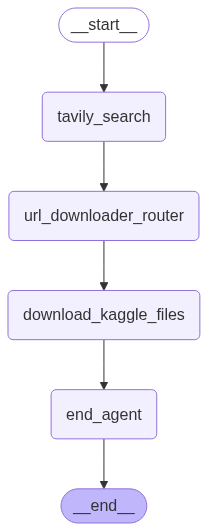

In [14]:
from langgraph.graph import StateGraph, START, END

graph = StateGraph(SourcingAgentState)

graph.add_node("tavily_search", tavily_search_tool)
graph.add_node("download_kaggle_files", download_kaggle_files)
graph.add_node("url_downloader_router", url_downloader_router)
graph.add_node("end_agent", end_agent)

graph.add_edge(START, "tavily_search")
graph.add_edge("tavily_search", "url_downloader_router")
graph.add_edge("url_downloader_router", "download_kaggle_files")
graph.add_edge("download_kaggle_files", "end_agent")

final_graph = graph.compile()

from IPython.display import Image, display
display(Image(final_graph.get_graph().draw_mermaid_png()))



In [17]:
query = "Climate Change 2024"

state = SourcingAgentState(query=query)


In [18]:
for event in final_graph.stream(state):
    print(event)

{'tavily_search': {'tavilySearchOutput': [TavilySearchOutput(title='Climate Change Dataset - Kaggle', url='https://www.kaggle.com/datasets/bhadramohit/climate-change-dataset', content='Climate Change Dataset Climate Change Dataset This dataset provides a comprehensive overview of key climate change indicators collected across different countries from the year 2000 to 2024. The country or region where the climate data was collected. The data can be used for machine learning models to predict future climate scenarios, especially in relation to global temperature rise, sea-level changes, and extreme weather events. File Name: climate_change_dataset.csv The year in which the data was recorded (from 2000 to 2024).text_format Country sort The country or region for which the climate data is recorded. The average annual temperature in degrees Celsius for each country.grid_3x3 CO2 Emissions (Tons/Capita)sort The annual sea-level rise in millimeters for coastal regions of the country.grid_3x3 Ra